In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, ResNet50V2, EfficientNetB2, EfficientNetB7, InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

2025-12-12 21:56:06.828214: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-12 21:56:07.802935: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-12 21:56:10.122507: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# === CONFIG ===
BASE_PATH = "datasets"  # ganti sesuai folder lo
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20

train_path = os.path.join(BASE_PATH, "train")
test_path = os.path.join(BASE_PATH, "test")

In [3]:
# === DATA LOADER ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 1200 images belonging to 4 classes.


Found 400 images belonging to 4 classes.


## Single Layer

In [4]:
# === MODEL TRANSFER LEARNING ===
# base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights="imagenet")
# base_model.trainable = False  # Freeze pretrained layer dulu

# base_model = ResNet50V2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights="imagenet")
# base_model.trainable = False

# base_model = InceptionV3(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights="imagenet")
# base_model.trainable = False

# x = GlobalAveragePooling2D()(base_model.output)
# x = Dropout(0.3)(x)

# output_layer = Dense(len(train_generator.class_indices), activation="softmax")(x)

# model = Model(inputs=base_model.input, outputs=output_layer)

# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

## Hybrid Layer

In [5]:
# # --- BUILD DUAL-BACKBONE MODEL (FIXED) ---
num_classes = len(train_generator.class_indices)
# 1 single input
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# 2 backbones: instantiate WITHOUT input_shape so they don't create their own Input layers
mobilenet_backbone = MobileNetV2(include_top=False, weights="imagenet")
resnet_backbone = ResNet50V2(include_top=False, weights="imagenet")

# Freeze both initially
mobilenet_backbone.trainable = False
resnet_backbone.trainable = False

# Call both backbones on the SAME input tensor
m_feat = mobilenet_backbone(inputs)      # feature map from MobileNet
r_feat = resnet_backbone(inputs)         # feature map from ResNet

# Pool and combine
m_pool = GlobalAveragePooling2D()(m_feat)
r_pool = GlobalAveragePooling2D()(r_feat)

combined = Concatenate()([m_pool, r_pool])
combined = Dropout(0.35)(combined)

outputs = Dense(num_classes, activation="softmax")(combined)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

#model.summary()

/tmp/ipykernel_1424/2454637116.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_backbone = MobileNetV2(include_top=False, weights="imagenet")
I0000 00:00:1765551373.754177    1424 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4082 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


## Tribrid Layer

In [6]:
# # # --- BUILD DUAL-BACKBONE MODEL (FIXED) ---
# num_classes = len(train_generator.class_indices)
# # 1 single input
# inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# # 2 backbones: instantiate WITHOUT input_shape so they don't create their own Input layers
# mobilenet_backbone = MobileNetV2(include_top=False, weights="imagenet")
# resnet_backbone = ResNet50V2(include_top=False, weights="imagenet")
# inception_backbone = InceptionV3(include_top=False, weights="imagenet")

# # Freeze both initially
# mobilenet_backbone.trainable = False
# resnet_backbone.trainable = False
# inception_backbone.trainable = False

# # Call both backbones on the SAME input tensor
# m_feat = mobilenet_backbone(inputs)      # feature map from MobileNet
# r_feat = resnet_backbone(inputs)         # feature map from ResNet
# i_feat = inception_backbone(inputs)

# # Pool and combine
# m_pool = GlobalAveragePooling2D()(m_feat)
# r_pool = GlobalAveragePooling2D()(r_feat)
# i_pool = GlobalAveragePooling2D()(i_feat)

# combined = Concatenate()([m_pool, r_pool, i_pool])
# combined = Dropout(0.35)(combined)

# outputs = Dense(num_classes, activation="softmax")(combined)

# model = Model(inputs=inputs, outputs=outputs)

# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# #model.summary()

## Qubrid Layer

In [7]:
# # # --- BUILD DUAL-BACKBONE MODEL (FIXED) ---
# num_classes = len(train_generator.class_indices)
# # 1 single input
# inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# # 2 backbones: instantiate WITHOUT input_shape so they don't create their own Input layers
# mobilenet_backbone = MobileNetV2(include_top=False, weights="imagenet")
# resnet_backbone = ResNet50V2(include_top=False, weights="imagenet")
# inception_backbone = InceptionV3(include_top=False, weights="imagenet")
# efficient_backbone = EfficientNetB2(include_top=False, weights="imagenet")

# # Freeze both initially
# mobilenet_backbone.trainable = False
# resnet_backbone.trainable = False
# inception_backbone.trainable = False
# efficient_backbone.trainable = False

# # Call both backbones on the SAME input tensor
# m_feat = mobilenet_backbone(inputs)      # feature map from MobileNet
# r_feat = resnet_backbone(inputs)         # feature map from ResNet
# i_feat = inception_backbone(inputs)
# e_feat = efficient_backbone(inputs)

# # Pool and combine
# m_pool = GlobalAveragePooling2D()(m_feat)
# r_pool = GlobalAveragePooling2D()(r_feat)
# i_pool = GlobalAveragePooling2D()(i_feat)
# e_pool = GlobalAveragePooling2D()(e_feat)

# combined = Concatenate()([m_pool, r_pool, i_pool, e_pool])
# combined = Dropout(0.35)(combined)

# outputs = Dense(num_classes, activation="softmax")(combined)

# model = Model(inputs=inputs, outputs=outputs)

# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# model.summary()

In [8]:
# === CALLBACKS ===
checkpoint = ModelCheckpoint("coffee_model.h5", monitor="val_accuracy", save_best_only=True)
earlystop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

In [9]:
# === TRAIN ===
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=[checkpoint, earlystop]
)

Epoch 1/20


2025-12-12 21:56:23.370783: I external/local_xla/xla/service/service.cc:163] XLA service 0x7068ac019d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-12 21:56:23.370837: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2025-12-12 21:56:23.594642: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-12 21:56:25.283244: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-12-12 21:56:32.225207: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-12 21:56:32.464181: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed

 3/38 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.1927 - loss: 2.1528

2025-12-12 21:56:46.408957: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-12 21:56:46.625095: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-12 21:56:46.851662: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-12 21:56:47.085695: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-12 21:56:47.139886: E external/local_xla/xla/service

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.4904 - loss: 1.2822

38/38 ━━━━━━━━━━━━━━━━━━━━ 54s 861ms/step - accuracy: 0.6833 - loss: 0.7988 - val_accuracy: 0.9775 - val_loss: 0.1671
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 237ms/step - accuracy: 0.9233 - loss: 0.2275 - val_accuracy: 0.9600 - val_loss: 0.1336
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9353 - loss: 0.1686

38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 255ms/step - accuracy: 0.9442 - loss: 0.1561 - val_accuracy: 0.9800 - val_loss: 0.0684
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.9625 - loss: 0.1288 - val_accuracy: 0.9750 - val_loss: 0.0688
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9713 - loss: 0.1082

38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - accuracy: 0.9625 - loss: 0.1121 - val_accuracy: 0.9925 - val_loss: 0.0441
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.9745 - loss: 0.0877

38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step - accuracy: 0.9717 - loss: 0.0934 - val_accuracy: 0.9950 - val_loss: 0.0434
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9708 - loss: 0.0907

38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - accuracy: 0.9717 - loss: 0.0902 - val_accuracy: 0.9975 - val_loss: 0.0302
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 227ms/step - accuracy: 0.9733 - loss: 0.0742 - val_accuracy: 0.9875 - val_loss: 0.0353
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 239ms/step - accuracy: 0.9783 - loss: 0.0708 - val_accuracy: 0.9975 - val_loss: 0.0233
Epoch 10/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.9797 - loss: 0.0605

38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 263ms/step - accuracy: 0.9708 - loss: 0.0790 - val_accuracy: 1.0000 - val_loss: 0.0198
Epoch 11/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 237ms/step - accuracy: 0.9842 - loss: 0.0575 - val_accuracy: 0.9900 - val_loss: 0.0286
Epoch 12/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step - accuracy: 0.9867 - loss: 0.0456 - val_accuracy: 0.9950 - val_loss: 0.0247
Epoch 13/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - accuracy: 0.9892 - loss: 0.0513 - val_accuracy: 0.9975 - val_loss: 0.0180
Epoch 14/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 235ms/step - accuracy: 0.9808 - loss: 0.0605 - val_accuracy: 1.0000 - val_loss: 0.0143
Epoch 15/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 237ms/step - accuracy: 0.9867 - loss: 0.0489 - val_accuracy: 1.0000 - val_loss: 0.0155
Epoch 16/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.9917 - loss: 0.0399 - val_accuracy: 0.9975 - val_loss: 0.0165
Epoch 17/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - accuracy: 0.9875 - loss: 0.0447 - val_accuracy: 0.997

In [10]:
# === EVALUATION ===
loss, acc = model.evaluate(test_generator)
print(f"\n🔥 Model Accuracy: {acc * 100:.2f}%")
print(f"📉 Model Loss: {loss:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 1.0000 - loss: 0.0109

🔥 Model Accuracy: 100.00%
📉 Model Loss: 0.0109


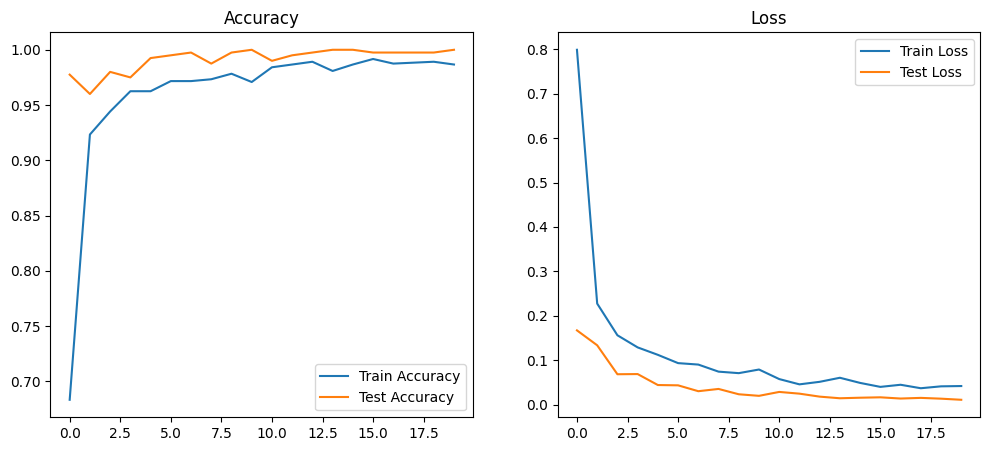

In [11]:
# === VISUALIZE TRAINING ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Test Accuracy")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Test Loss")
plt.title("Loss")
plt.legend()

plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 518ms/step
              precision    recall  f1-score   support

        Dark       1.00      1.00      1.00       100
       Green       1.00      1.00      1.00       100
       Light       1.00      1.00      1.00       100
      Medium       1.00      1.00      1.00       100

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



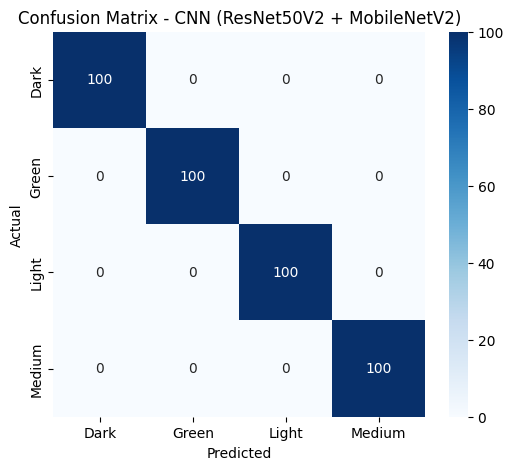

In [12]:
# Ambil label ground truth dari generator
y_true = test_generator.classes  
class_labels = list(test_generator.class_indices.keys())

# Prediksi model (probability → argmax)
y_pred = model.predict(test_generator)
y_pred_class = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred_class, target_names=class_labels))

# =============================
#  CONFUSION MATRIX
# =============================

cm = confusion_matrix(y_true, y_pred_class)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - CNN (ResNet50V2 + MobileNetV2)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()